## VAE Results

In [1]:
import pandas as pd
import torch
import sys
import os
from PIL import Image
from torchvision import transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sys.path.append('/home/juandres/aml/CheXBias/src/')
from general_functions import *
import scipy.stats

### Import model

In [2]:
# Set the target GPU
device = torch.device('cuda:1')

# Move the entire process to the specified GPU
torch.cuda.set_device(device)

# Array with all VAE
all_vae = []

# Iterate over all models
for sex_group in [0,20,40,60,80,100]:

    # Instantiate the VAE
    vae = AdaptableVAE(input_channels=1, latent_size=2*64, input_size=224).to(device)

    # Load pre-trained weights
    vae.load_state_dict(torch.load(f'/home/juandres/aml/CheXBias/models/Experiment_2/sex/female_{sex_group}/best_vae.pth', map_location={'cuda:0': 'cuda:1'}))

    all_vae.append(vae)

### Training Results

/home/juandres/anaconda3/envs/pytorch_new/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/juandres/anaconda3/envs/pytorch_new/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/juandres/anaconda3/envs/pytorch_new/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/juandres/anaconda3/envs/pytorch_new/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

Text(0, 0.5, '')

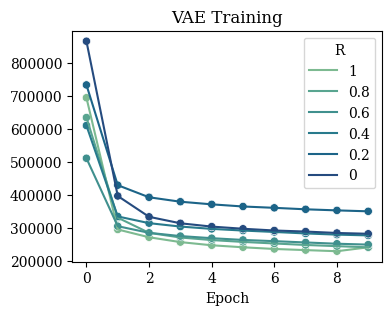

In [3]:
plt.rcParams["font.family"] = "Serif"
tr = pd.read_csv('/home/juandres/aml/CheXBias/reports/VAE/vae_training.csv',delimiter=';').set_index('Epoch')
tr = tr.melt()
tr['Epoch'] = [i % 10 for i in range(60)]
tr.rename(columns={'variable': 'R'}, inplace=True)

fig = plt.figure(figsize=(4,3))
sns.lineplot(data = tr, x = 'Epoch',y = 'value',hue = 'R',palette='crest')
sns.scatterplot(data = tr, x = 'Epoch',y = 'value',hue = 'R',palette='crest',legend=False).set_title('VAE Training')
plt.ylabel('')


### Load sample images


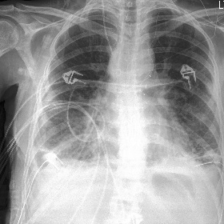

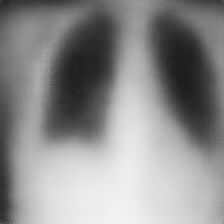

In [4]:
# List all test images
path_test = '/home/juandres/aml/CheXBias/data_new/processed/test'
images = os.listdir(path_test)

# Load single image
img = Image.open(os.path.join(path_test,images[1])).convert('L')  # 'L' mode for grayscale
# Define pre-process
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=1),  # Convert grayscale to specified number of channels
    transforms.ToTensor()
    ])
img = preprocess(img)
display(transforms.ToPILImage()(img))
vae_output = vae(img.unsqueeze(1).to(device))
img_reconstructed = vae_output[0].squeeze(0)
transforms.ToPILImage()(img_reconstructed[0].cpu())

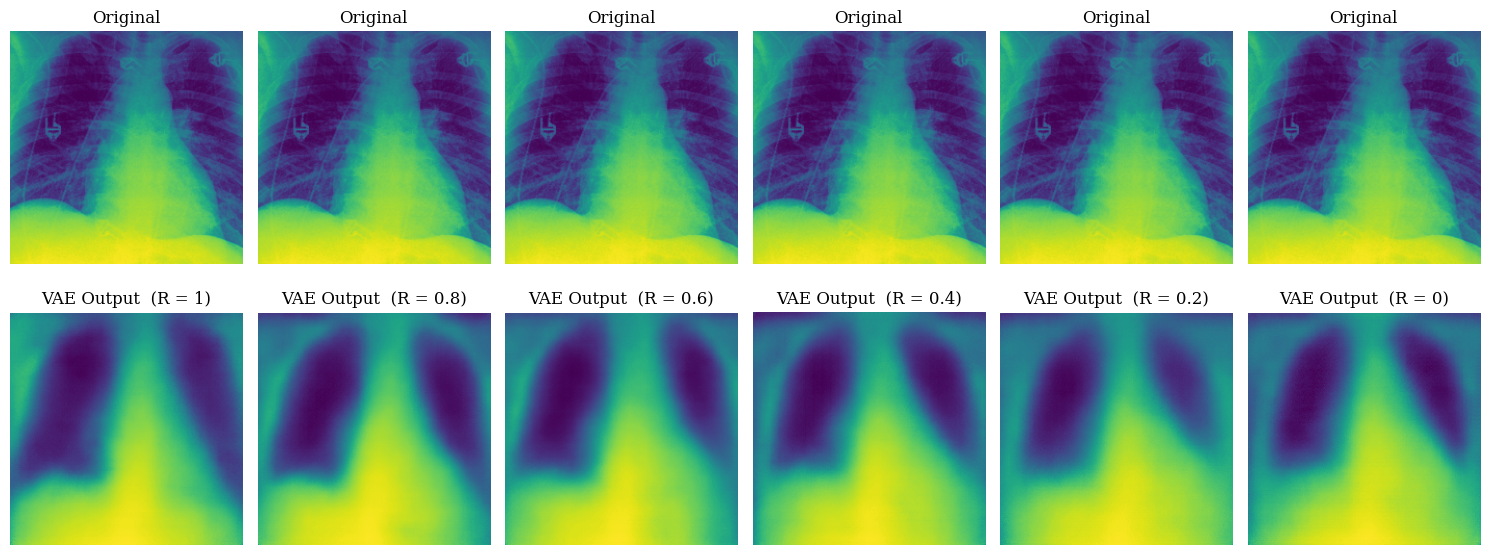

: 

In [214]:
# List all test images
path_test = '/home/juandres/aml/CheXBias/data_new/processed/test'
images = os.listdir(path_test)

# Load single image
img = Image.open(os.path.join(path_test,images[5])).convert('L')  # 'L' mode for grayscale
# Define pre-process
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=1),  # Convert grayscale to specified number of channels
    transforms.ToTensor()
    ])
img = preprocess(img)

# Set up the figure
num_vaes = len(all_vae)
fig, axs = plt.subplots(2, num_vaes, figsize=(15, 6))

# R array
R = [1,0.8,0.6,0.4,0.2,0]

# Iterate over each VAE
for i, vae in enumerate(all_vae):

    # Get the prediction for each VAE
    vae_output = vae(img.unsqueeze(1).to(device))
    img_reconstructed = vae_output[0].squeeze(0)

    # Images to display
    reconstructed_img = transforms.ToPILImage()(img_reconstructed[0].cpu())
    original_processed_img = transforms.ToPILImage()(img)

    # Display the images
    axs[0, i].imshow(original_processed_img)
    axs[0, i].set_title('Original')
    axs[0, i].axis('off')

    axs[1, i].imshow(reconstructed_img)
    axs[1, i].set_title(f'VAE Output  (R = {R[i]})')
    axs[1, i].axis('off')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

### Create Joint histogram for each latent variable 

In [189]:
all_df = pd.DataFrame()

for j,group in enumerate([0,20,40,60,80,100]):

    # Load mean for each one of the latent features per image
    latent_mean_df = pd.read_csv('/home/juandres/aml/CheXBias/models/Experiment_2/sex/female_'+str(group)+'/distributions.csv')
    latent_mean = latent_mean_df[latent_mean_df.columns[1:]].to_numpy()

    # Iterate over all latent features

    # Save again the latent_mean_pro
    latent_mean_prob = []

    for i in range(0,latent_mean.shape[1]):

        # Get all the mean values for this latent features
        latent_mean_tmp = latent_mean[:,i]

        # Get mean and std of the distribution
        mean_latent = latent_mean_tmp.mean()
        std_latent = latent_mean_tmp.std()

        # Get a probability value for each sample in the latent features
        latent_prob = scipy.stats.norm.pdf(latent_mean_tmp, loc=mean_latent, scale=std_latent)

        latent_mean_prob.append(latent_prob)

    latent_mean_prob_array = np.stack(latent_mean_prob,axis=1)

    SumProb = pd.DataFrame(latent_mean_prob_array.sum(axis=1),index=latent_mean_df['file_name'],columns=['SumProb'])
    SumProb = SumProb.sort_values(by='SumProb',ascending=False)
    SumProb = SumProb.reset_index()
    split_columns = SumProb['file_name'].str.split('_', expand=True)
    split_columns.columns = ['patient','study','view','perspective','sex','Age','perspective1','ap_pa']
    SumProb1 = pd.concat([SumProb, split_columns], axis=1)
    SumProb1['Age'] = SumProb1['Age'].astype(int)

    # Handle projection
    SumProb1['projection'] = SumProb1['ap_pa'].str.split('.').str[0]
    SumProb1 = SumProb1[SumProb1['projection'] != 'nan']

    # First 10 images
    top_images = SumProb.head(10).reset_index()
    bottom_images = SumProb.tail(10).reset_index()

    # Group by 'perspective1' and calculate the mean and standard deviation
    grouped_data = SumProb1.groupby('projection')['SumProb'].agg(['mean', 'std']).reset_index()
    
    # Add R
    grouped_data['R'] = R[j]
    
    # Use sns.barplot with standard deviation error bars
    all_df = pd.concat([all_df,grouped_data])
    #sns.barplot(data=grouped_data, x='perspective', y='mean', yerr=grouped_data['std'], palette='crest')

In [ ]:
SumProb1['projections'] = SumProb1['ap_pa'].str.split('.').str[0]
SumProb1[SumProb1['projections'] != 'nan']

/home/juandres/anaconda3/envs/pytorch_new/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/juandres/anaconda3/envs/pytorch_new/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/juandres/anaconda3/envs/pytorch_new/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/juandres/anaconda3/envs/pytorch_new/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

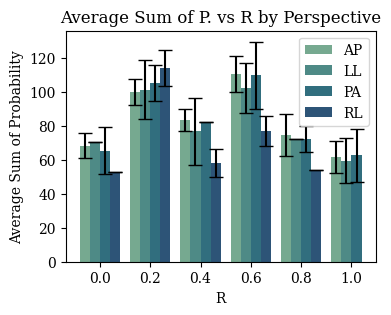

In [193]:
# Create the bar plot
fig = plt.figure(figsize=(4,3))
ax = sns.barplot(data=all_df, x='R', y='mean', hue='projection', palette='crest')

# Add error bars manually
for bar, error in zip(ax.patches, all_df['std']):
    if math.isnan(error):
        error=0
    else:
        pass
    ax.errorbar(
        bar.get_x() + bar.get_width() / 2,  # X coordinate of the bar's center
        bar.get_height(),  # Y coordinate of the bar's top
        yerr=error,
        color='black',  # Optional: Set the color of the error bars
        capsize=5,  # Optional: Set the size of the caps at the end of the error bars
    )

# Optional: Customize the plot further if needed
plt.title('Average Sum of P. vs R by Perspective')
plt.xlabel('R')
plt.ylabel('Average Sum of Probability')
plt.legend(title='Perspective')
plt.legend(loc = "upper right")

plt.show()

/home/juandres/anaconda3/envs/pytorch_new/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/juandres/anaconda3/envs/pytorch_new/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/juandres/anaconda3/envs/pytorch_new/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/juandres/anaconda3/envs/pytorch_new/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

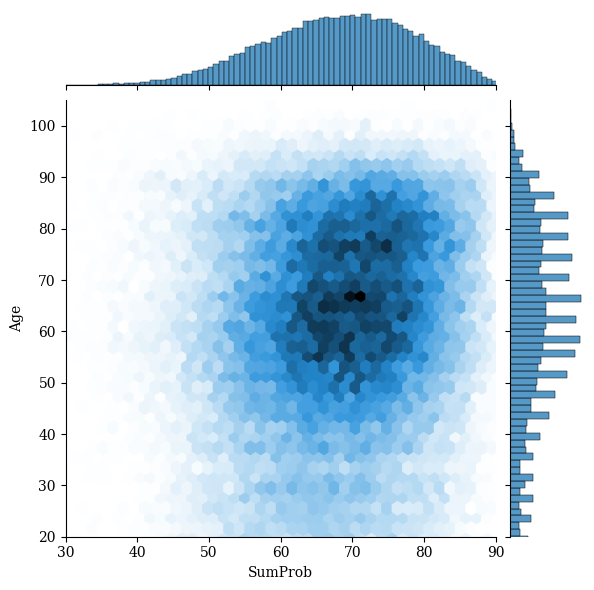

In [210]:
#sns.histplot(data=SumProb1, x='SumProb', y='Age', cbar=True, cmap='viridis', bins=50)
sns.jointplot(data=SumProb1, x='SumProb', y='Age', kind='hex', palette='crest')
#sns.jointplot(data=SumProb1, x='SumProb', y='Age', palette='crest',hue='perspective')
plt.xlim([30,90])
plt.ylim([20,105])
plt.show()

In [199]:
SumProb1

,file_name,SumProb,patient,study,view,perspective,sex,Age,perspective1,ap_pa,projection
0,patient27408_study5_view1_frontal_Female_87_Fr...,91.747533,patient27408,study5,view1,frontal,Female,87,Frontal,AP.jpg,AP
1,patient03482_study3_view1_frontal_Female_70_Fr...,91.596174,patient03482,study3,view1,frontal,Female,70,Frontal,AP.jpg,AP
2,patient22308_study1_view1_frontal_Female_89_Fr...,91.481438,patient22308,study1,view1,frontal,Female,89,Frontal,AP.jpg,AP
3,patient06655_study17_view1_frontal_Female_49_F...,91.465107,patient06655,study17,view1,frontal,Female,49,Frontal,AP.jpg,AP
4,patient06655_study18_view1_frontal_Female_49_F...,91.465107,patient06655,study18,view1,frontal,Female,49,Frontal,AP.jpg,AP
...,...,...,...,...,...,...,...,...,...,...,...
72570,patient28667_study1_view1_frontal_Female_60_Fr...,25.522769,patient28667,study1,view1,frontal,Female,60,Frontal,PA.jpg,PA
72571,patient11746_study1_view1_frontal_Female_24_Fr...,25.280833,patient11746,study1,view1,frontal,Female,24,Frontal,PA.jpg,PA
72573,patient24678_study1_view1_frontal_Female_70_Fr...,23.122314,patient24678,study1,view1,frontal,Female,70,Frontal,PA.jpg,PA
72574,patient01997_study7_view1_frontal_Female_67_Fr...,22.829380,patient01997,study7,view1,frontal,Female,67,Frontal,PA.jpg,PA


In [ ]:
# Show Images for both cases
for image in bottom_images['file_name']:
    img = Image.open(os.path.join('/home/juandres/aml/CheXBias/data_new/processed/train',image)).convert('L')
    display(img)

In [89]:
xx = [el.split('_')[5] for el in bottom_images['file_name']]
yy = [el.split('_')[5] for el in top_images['file_name']]

print('Bottom')
print(np.array(xx).astype(int).mean())
print(np.array(xx).astype(int).std())
print('Top')
print(np.array(yy).astype(int).mean())
print(np.array(yy).astype(int).std())

Bottom
63.1
17.23629890666787
Top
72.4
14.143549766589716


In [91]:
print('Bottom')
display(pd.DataFrame(xx).value_counts())
print('Top')
display(pd.DataFrame(yy).value_counts())

Bottom


60    2
67    2
86    2
24    1
46    1
65    1
70    1
Name: count, dtype: int64

Top


49    2
61    1
70    1
74    1
78    1
83    1
84    1
87    1
89    1
Name: count, dtype: int64

### Other stuff

<Axes: >

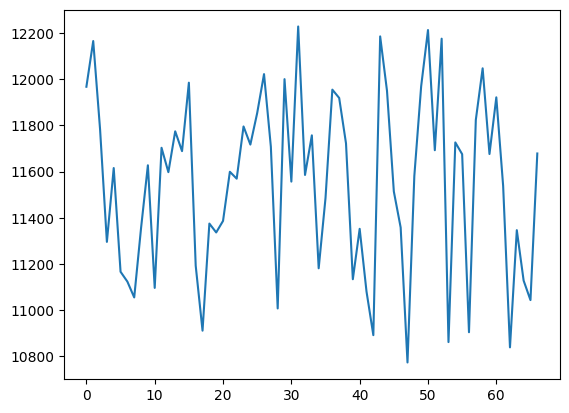

In [38]:
import matplotlib.pyplot as plt
df = pd.read_csv('/home/juandres/aml/CheXBias/reports/VAE/mse_loss.csv')
df[df.columns[2]].plot()